# Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Thesis/CNN.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Thesis/Bongard Testing.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import os
from os import path
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Input
from sklearn.metrics import accuracy_score
import time
import natsort
from PIL import Image
start_time = time.time()

# Functions:

#### 1) Function to plot bongard images

In [5]:
def load_and_resize_images(folder_path, target_size):
    image_paths = glob.glob(os.path.join(folder_path, '*.png'))
    image_paths = natsort.natsorted(image_paths)
    images = []
    for img_path in image_paths:
        with Image.open(img_path) as img:
            img = img.resize(target_size)
            if img.mode == 'RGBA':
                img = img.convert('L')
            img_arr = np.array(img)
            if len(img_arr.shape) == 2:
                img_arr = img_arr[..., np.newaxis]
            images.append(img_arr)
    return np.array(images)

def plot_image_from_array(images_array, image_index, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(images_array[image_index, :, :, 0], cmap='gray', aspect='auto')
    plt.title(f"Image {image_index + 1}")
    plt.axis('off')
    plt.show()

folder_B_path = '/content/Bongard Testing/BP'
target_size = (330, 516)
images_array = load_and_resize_images(folder_B_path, target_size)

#### 2) Function to preprocess images

In [6]:
# Preprocessing:
def load_imgs(list_of_img_paths):
    alpaca_lst = []
    for imgs in list_of_img_paths:
        img=tf.keras.utils.load_img(
                            imgs,
                            color_mode = "grayscale",
                            target_size=None,
                            interpolation="nearest",
                            keep_aspect_ratio=False)

        input_arr = tf.keras.utils.img_to_array(img)

        inpt_img_arr = input_arr / 255.0
        alpaca_lst.append(inpt_img_arr)
    imgs_arr =np.array(alpaca_lst)
    return imgs_arr

#### 3) Function to plot any image with their labels

In [7]:
import matplotlib.pyplot as plt

def plot_images_with_labels(images, labels):
    plt.figure(figsize=(12, 8))

    for i in range(len(images)):
        plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns for a 2x5 grid of subplots
        plt.imshow(images[i], cmap='gray')  # Display the image
        plt.title(f'Label: {labels[i]}')    # Set the title with the corresponding label
        plt.axis('off')                     # Turn off axis labels and ticks

    plt.tight_layout()
    plt.show()

#### 4) functions to create masked labels

In [8]:
# Generate masked labels for heads except selected head
def create_masked_labels(selected_head_name, excluded_head_names, labels):
    masked_labels = {}
    masked_labels[selected_head_name] = labels
    for head_name in excluded_head_names:
        masked_labels[head_name] = np.full_like(labels, -1)
    return masked_labels
def masked_label(selected_head_name,Ci_y_train):
    # Define the list of output head layer names
    output_names = ['center_vs_notincenter','circle_vs_notcircle','Closed_vs_Open_figure',
                'Colinear_vs_Noncolinear','Concave_vs_Convex','Four_vs_notfour_side','Triangle_vs_notTriangle',
                'Clockwise_vs_Anticlock_wise','Left_vs_Right','Parallel_vs_perpendicular','Filled_vs_Unfilled',
                'Complete_vs_Incomplete','Intersect_vs_NonIntersect','M_cluster_vs_N_clusters','Above_vs_Below',
                'Same_vs_Not_Same','Size_big_vs_Small','Symmetery_vs_Non_symmetery','Horizontal_vs_Vertical',
                'Empty_vs_Non_Empty']

    # Exclude the selected head from generating masked labels
    excluded_head_names = [name for name in output_names if name != selected_head_name]

    # Generate masked labels for all excluded heads
    Ci_masked_labels = create_masked_labels(selected_head_name, excluded_head_names, Ci_y_train)
    return Ci_masked_labels

#### 5) Function to preprocess and split the data into training and testing

In [9]:
def data_load_split(Classifier_path,folder_A,folder_B):
    os.getcwd()
    dataset_path = os.getcwd()
    a = os.path.join('/content/CNN',Classifier_path)
    A = os.path.join(dataset_path, a)
    A_A = os.path.join(A, folder_A)
    A_B = os.path.join(A, folder_B)
    A_A = glob.glob(A_A +"/*.png")
    A_B = glob.glob(A_B +"/*.png")
    A_A_arr =load_imgs(A_A)
    A_B_arr =load_imgs(A_B)


    # Generate labels corresponding to above concept classes.
    A_A_labels =  np.zeros([len(A_A_arr), 1], dtype = int)  #labeled as 0
    A_B_labels =  np.ones([len(A_B_arr), 1], dtype = int) #labeled as 1

    Ci_X = np.concatenate((A_A_arr, A_B_arr), axis=0)
    Ci_y = np.concatenate((A_A_labels , A_B_labels), axis=0)

    # Split the data into training and testing sets
    Ci_X_train, Ci_X_test, Ci_y_train, Ci_y_test = train_test_split(Ci_X, Ci_y,
                                                                    test_size=0.2, random_state=42, shuffle=True)

    return Ci_X_train,Ci_X_test,Ci_y_train,Ci_y_test

#### Automate the code to load every classifier images and split.

In [10]:
# Path to the main folder
main_folder_path = "/content/CNN"

# Get the names of first-level subfolders in "A"
subfolder_names = [name for name in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, name))]
subfolder_names = sorted(subfolder_names)
start_time = time.time()
# Iterate through the first-level subfolders and call data_load_split
for i, subfolder_name in enumerate(subfolder_names):
    subfolder_path = os.path.join(main_folder_path, subfolder_name)
    subsubfolder_names = [name for name in os.listdir(subfolder_path) if os.path.isdir(os.path.join(subfolder_path, name))]

    if len(subsubfolder_names) == 2:
        print(f'classifier C{i}:', subfolder_name)
#         print(subsubfolder_names[0],subsubfolder_names[1])
        exec(f'C{i}_X_train, C{i}_X_test, C{i}_y_train, C{i}_y_test = data_load_split(subfolder_name,subsubfolder_names[0],subsubfolder_names[1])')
        print("Shape:")

        print(locals()[f'C{i}_X_train'].shape, locals()[f'C{i}_y_train'].shape,locals()[f'C{i}_X_test'].shape,
        locals()[f'C{i}_y_test'].shape)
        print('\n')
end_time = time.time()
Preprocess_Time = end_time - start_time
print("Time taken for Preprocess data:", Preprocess_Time, "seconds")

classifier C0: B) center  vs not incenter
Shape:
(3680, 100, 100, 1) (3680, 1) (920, 100, 100, 1) (920, 1)


classifier C1: C) Circle vs not circle
Shape:
(1600, 100, 100, 1) (1600, 1) (400, 100, 100, 1) (400, 1)


classifier C2: D) Closed figure vs Open figure
Shape:
(1232, 100, 100, 1) (1232, 1) (308, 100, 100, 1) (308, 1)


classifier C3: E) Co-linear vs Non-colinear
Shape:
(1600, 100, 100, 1) (1600, 1) (400, 100, 100, 1) (400, 1)


classifier C4: F) Concave vs Convex
Shape:
(1600, 100, 100, 1) (1600, 1) (400, 100, 100, 1) (400, 1)


classifier C5: G) Four sides vs not four side
Shape:
(5600, 100, 100, 1) (5600, 1) (1400, 100, 100, 1) (1400, 1)


classifier C6: H) Triangle vs not Triangle
Shape:
(5584, 100, 100, 1) (5584, 1) (1396, 100, 100, 1) (1396, 1)


classifier C7: I) Clockwise vs Anticlock wise
Shape:
(2400, 100, 100, 1) (2400, 1) (600, 100, 100, 1) (600, 1)


classifier C8: J) Left vs Right
Shape:
(2000, 100, 100, 1) (2000, 1) (500, 100, 100, 1) (500, 1)


classifier C9: K) 

# Multi-Head CNN

In [11]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model


def Multi_head_CNN():

  # Input Shape
  input_shape = (100, 100, 1)
  input_layer = Input(shape=input_shape)

  # CNN common model:
  CNN_L1 = Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu')(input_layer)
  CNN_L2 = BatchNormalization()(CNN_L1)
  CNN_L3 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(CNN_L2)

  CNN_L4 = Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu')(CNN_L3)
  CNN_L5 = BatchNormalization()(CNN_L4)
  CNN_L6 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(CNN_L5)

  CNN_L7 = Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu')(CNN_L6)
  CNN_L8 = BatchNormalization()(CNN_L7)
  CNN_L9 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(CNN_L8)

  CNN_L10 = Conv2D(128, kernel_size=(3, 3), padding='valid', activation='relu')(CNN_L9)
  CNN_L11 = BatchNormalization()(CNN_L10)
  CNN_L12 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(CNN_L11)

  CNN_L13 = Flatten()(CNN_L12)

  # Add more layers
  Common_Layer = Dense(128, activation='relu')(CNN_L13)
  Common_Layer = Dense(10, activation='relu')(Common_Layer)

  # Individual Head: Center vs not incenter
  center_vs_notincenter = Dense(1, activation='sigmoid', name='center_vs_notincenter')(Common_Layer)

  # Individual Head: Circle vs not circle
  circle_vs_notcircle = Dense(1, activation='sigmoid', name='circle_vs_notcircle')(Common_Layer)

  # Individual Head: Closed_vs_Open_figure
  Closed_vs_Open_figure = Dense(1, activation='sigmoid', name='Closed_vs_Open_figure')(Common_Layer)

  # Individual Head: Co-linear_vs_Non-colinear
  Colinear_vs_Noncolinear = Dense(1, activation='sigmoid', name='Colinear_vs_Noncolinear')(Common_Layer)

  # Individual Head: Concave_vs_Convex
  Concave_vs_Convex = Dense(1, activation='sigmoid', name='Concave_vs_Convex')(Common_Layer)


  Four_vs_notfour_side =Dense(1, activation='sigmoid', name='Four_vs_notfour_side')(Common_Layer)


  Triangle_vs_notTriangle =Dense(1, activation='sigmoid', name='Triangle_vs_notTriangle')(Common_Layer)


  Clockwise_vs_Anticlock_wise =  Dense(1, activation='sigmoid', name='Clockwise_vs_Anticlock_wise')(Common_Layer)


  Left_vs_Right =  Dense(1, activation='sigmoid', name='Left_vs_Right')(Common_Layer)


  Parallel_vs_perpendicular =  Dense(1, activation='sigmoid', name='Parallel_vs_perpendicular')(Common_Layer)


  Filled_vs_Unfilled =  Dense(1, activation='sigmoid', name='Filled_vs_Unfilled')(Common_Layer)


  Complete_vs_Incomplete =  Dense(1, activation='sigmoid', name='Complete_vs_Incomplete')(Common_Layer)


  Intersect_vs_NonIntersect =  Dense(1, activation='sigmoid', name='Intersect_vs_NonIntersect')(Common_Layer)


  M_cluster_vs_N_clusters =  Dense(1, activation='sigmoid', name='M_cluster_vs_N_clusters')(Common_Layer)


  Above_vs_Below =  Dense(1, activation='sigmoid', name='Above_vs_Below')(Common_Layer)


  Same_vs_Not_Same =  Dense(1, activation='sigmoid', name='Same_vs_Not_Same')(Common_Layer)

  Size_big_vs_Small =  Dense(1, activation='sigmoid', name='Size_big_vs_Small')(Common_Layer)

  Symmetery_vs_Non_symmetery = Dense(1, activation='sigmoid', name='Symmetery_vs_Non_symmetery')(Common_Layer)

  Horizontal_vs_Vertical = Dense(1, activation='sigmoid', name='Horizontal_vs_Vertical')(Common_Layer)

  Empty_vs_Non_Empty = Dense(1, activation='sigmoid', name='Empty_vs_Non_Empty')(Common_Layer)


  # Create the model
  model = Model(inputs=input_layer, outputs=[
                                            center_vs_notincenter,
                                            circle_vs_notcircle,
                                            Closed_vs_Open_figure,
                                            Colinear_vs_Noncolinear,
                                            Concave_vs_Convex,
                                            Four_vs_notfour_side,
                                            Triangle_vs_notTriangle,
                                            Clockwise_vs_Anticlock_wise,
                                            Left_vs_Right,
                                            Parallel_vs_perpendicular,
                                            Filled_vs_Unfilled,
                                            Complete_vs_Incomplete,
                                            Intersect_vs_NonIntersect,
                                            M_cluster_vs_N_clusters,
                                            Above_vs_Below,
                                            Same_vs_Not_Same,
                                            Size_big_vs_Small,
                                            Symmetery_vs_Non_symmetery,
                                            Horizontal_vs_Vertical,
                                            Empty_vs_Non_Empty
                                            ])

  # Compile the model with appropriate loss functions for each head
  model.compile(optimizer='adam',


                loss={
                'center_vs_notincenter': 'binary_crossentropy',
                'circle_vs_notcircle': 'binary_crossentropy',
                'Closed_vs_Open_figure': 'binary_crossentropy',
                'Colinear_vs_Noncolinear': 'binary_crossentropy',
                'Concave_vs_Convex': 'binary_crossentropy',
                'Four_vs_notfour_side': 'binary_crossentropy',
                'Triangle_vs_notTriangle': 'binary_crossentropy',
                'Clockwise_vs_Anticlock_wise': 'binary_crossentropy',
                'Left_vs_Right': 'binary_crossentropy',
                'Parallel_vs_perpendicular': 'binary_crossentropy',
                'Filled_vs_Unfilled': 'binary_crossentropy',
                'Complete_vs_Incomplete': 'binary_crossentropy',
                'Intersect_vs_NonIntersect': 'binary_crossentropy',
                'M_cluster_vs_N_clusters': 'binary_crossentropy',
                'Above_vs_Below': 'binary_crossentropy',
                'Same_vs_Not_Same': 'binary_crossentropy',
                'Size_big_vs_Small':'binary_crossentropy',
                'Symmetery_vs_Non_symmetery':'binary_crossentropy',
                'Horizontal_vs_Vertical':'binary_crossentropy',
                'Empty_vs_Non_Empty':'binary_crossentropy',
                })
  return model

In [12]:
model=Multi_head_CNN()

### Training Models

In [13]:
Final_test_accuracies = []

In [14]:
X = [C0_X_train, C1_X_train,C2_X_train,C3_X_train, C4_X_train,C5_X_train,C6_X_train, C7_X_train,C8_X_train,C9_X_train,
     C10_X_train,C11_X_train,C12_X_train, C13_X_train,C14_X_train,C15_X_train,C16_X_train,C17_X_train,C18_X_train,
     C19_X_train]

Y=  [C0_y_train,C1_y_train,C2_y_train,C3_y_train,C4_y_train,C5_y_train,C6_y_train,C7_y_train,C8_y_train,C9_y_train,
C10_y_train,C11_y_train,C12_y_train,C13_y_train,C14_y_train,C15_y_train,C16_y_train,C17_y_train,C18_y_train,C19_y_train,]

output_names = ['center_vs_notincenter','circle_vs_notcircle','Closed_vs_Open_figure',
                'Colinear_vs_Noncolinear','Concave_vs_Convex','Four_vs_notfour_side','Triangle_vs_notTriangle',
                'Clockwise_vs_Anticlock_wise','Left_vs_Right','Parallel_vs_perpendicular','Filled_vs_Unfilled',
                'Complete_vs_Incomplete','Intersect_vs_NonIntersect','M_cluster_vs_N_clusters','Above_vs_Below',
                'Same_vs_Not_Same','Size_big_vs_Small','Symmetery_vs_Non_symmetery','Horizontal_vs_Vertical',
                'Empty_vs_Non_Empty']

#### Cheking accuracy on each classifier

In [15]:
def check_accuracy1(X_test,Y_test,i):

  predictions = model.predict(X_test)
  predictions_head = predictions[i]
  threshold = 0.5
  binary_predictions_head = (predictions_head > threshold).astype(int)
  print("binary_predictions_head: ",np.unique(binary_predictions_head))
  accuracy_classifier = accuracy_score(Y_test, binary_predictions_head)
  print(f'Accuracy for Classifier C{i}:', accuracy_classifier)
  return accuracy_classifier

In [16]:
training_loss_epoch_0=[]
training_loss_epoch_1=[]
training_loss_epoch_2=[]
training_loss_epoch_3=[]
training_loss_epoch_4=[]
training_loss_epoch_5=[]
training_loss_epoch_6=[]
training_loss_epoch_7=[]
training_loss_epoch_8=[]
training_loss_epoch_9=[]

### Head 0 checking

In [18]:
Model_history=model.fit(X[0], {output_names[0]: Y[0]}, epochs=10)

Temp_var=check_accuracy1(C0_X_test,C0_y_test,0)
Rounded_accuracy = round(Temp_var, 2)
Final_test_accuracies.append(Rounded_accuracy)
print("Final_test_accuracies till now: ",Final_test_accuracies)

Training_loss=Model_history.history['loss']
for i in range(10):
  globals()[f'training_loss_epoch_{i}'].append(Training_loss[i])

Epoch 1/10
115/115 [==============================] - 1s 8ms/step - loss: 0.0349 - center_vs_notincenter_loss: 0.0349 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Epoch 2/10
115/115 [==============================] - 1s 8ms/step - loss: 0.0223 - center_vs_notincenter_loss: 0.

### Head 1 checking

In [19]:
Model_history=model.fit(X[1], {output_names[1]: Y[1]}, epochs=10)

Temp_var=check_accuracy1(C1_X_test,C1_y_test,1)
Rounded_accuracy = round(Temp_var, 2)
Final_test_accuracies.append(Rounded_accuracy)
print("Final_test_accuracies till now: ",Final_test_accuracies)

Training_loss=Model_history.history['loss']
for i in range(10):
  globals()[f'training_loss_epoch_{i}'].append(Training_loss[i])

Epoch 1/10


50/50 [==============================] - 1s 7ms/step - loss: 0.2875 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.2875 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Epoch 2/10
50/50 [==============================] - 0s 7ms/step - loss: 0.0578 - center_vs_notincenter_loss: 0.0000e+00 - circ

### Head 2 checking

In [20]:
Model_history=model.fit(X[2], {output_names[2]: Y[2]}, epochs=10)

Temp_var=check_accuracy1(C2_X_test,C2_y_test,2)
Rounded_accuracy = round(Temp_var, 2)
Final_test_accuracies.append(Rounded_accuracy)
print("Final_test_accuracies till now: ",Final_test_accuracies)

Training_loss=Model_history.history['loss']
for i in range(10):
  globals()[f'training_loss_epoch_{i}'].append(Training_loss[i])

Epoch 1/10


39/39 [==============================] - 1s 9ms/step - loss: 0.6340 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.6340 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Epoch 2/10
39/39 [==============================] - 0s 8ms/step - loss: 0.4149 - center_vs_notincenter_loss: 0.0000e+00 - circ

### Head 3 checking

In [21]:
Model_history=model.fit(X[3], {output_names[3]: Y[3]}, epochs=10)

Temp_var=check_accuracy1(C3_X_test,C3_y_test,3)
Rounded_accuracy = round(Temp_var, 2)
Final_test_accuracies.append(Rounded_accuracy)
print("Final_test_accuracies till now: ",Final_test_accuracies)

Training_loss=Model_history.history['loss']
for i in range(10):
  globals()[f'training_loss_epoch_{i}'].append(Training_loss[i])

Epoch 1/10


50/50 [==============================] - 2s 8ms/step - loss: 0.6635 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.6635 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Epoch 2/10
50/50 [==============================] - 0s 8ms/step - loss: 0.4161 - center_vs_notincenter_loss: 0.0000e+00 - circ

#### Head 4 checking

In [22]:
Model_history=model.fit(X[4], {output_names[4]: Y[4]}, epochs=10)

Temp_var=check_accuracy1(C4_X_test,C4_y_test,4)
Rounded_accuracy = round(Temp_var, 2)
Final_test_accuracies.append(Rounded_accuracy)
print("Final_test_accuracies till now: ",Final_test_accuracies)

Training_loss=Model_history.history['loss']
for i in range(10):
  globals()[f'training_loss_epoch_{i}'].append(Training_loss[i])

Epoch 1/10


50/50 [==============================] - 1s 7ms/step - loss: 0.7433 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.7433 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Epoch 2/10
50/50 [==============================] - 0s 7ms/step - loss: 0.6440 - center_vs_notincenter_loss: 0.0000e+00 - circ

#### Head 5 checking

In [23]:
Model_history=model.fit(X[5], {output_names[5]: Y[5]}, epochs=10)

Temp_var=check_accuracy1(C5_X_test,C5_y_test,5)
Rounded_accuracy = round(Temp_var, 2)
Final_test_accuracies.append(Rounded_accuracy)
print("Final_test_accuracies till now: ",Final_test_accuracies)

Training_loss=Model_history.history['loss']
for i in range(10):
  globals()[f'training_loss_epoch_{i}'].append(Training_loss[i])

Epoch 1/10


175/175 [==============================] - 2s 7ms/step - loss: 0.7472 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.7472 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Epoch 2/10
175/175 [==============================] - 1s 7ms/step - loss: 0.3561 - center_vs_notincenter_loss: 0.0000e+00 - 

#### Head 6 checking

In [24]:
Modek_history=model.fit(X[6], {output_names[6]: Y[6]}, epochs=10)

Temp_var=check_accuracy1(C6_X_test,C6_y_test,6)
Rounded_accuracy = round(Temp_var, 2)
Final_test_accuracies.append(Rounded_accuracy)
print("Final_test_accuracies till now: ",Final_test_accuracies)

Training_loss=Model_history.history['loss']
for i in range(10):
  globals()[f'training_loss_epoch_{i}'].append(Training_loss[i])

Epoch 1/10


175/175 [==============================] - 2s 8ms/step - loss: 0.6306 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.6306 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Epoch 2/10
175/175 [==============================] - 1s 7ms/step - loss: 0.4879 - center_vs_notincenter_loss: 0.0000e+00 - 

#### Head 7 checking

In [25]:
Model_history=model.fit(X[7], {output_names[7]: Y[7]}, epochs=10)

Temp_var=check_accuracy1(C7_X_test,C7_y_test,7)
Rounded_accuracy = round(Temp_var, 2)
Final_test_accuracies.append(Rounded_accuracy)
print("Final_test_accuracies till now: ",Final_test_accuracies)

Training_loss=Model_history.history['loss']
for i in range(10):
  globals()[f'training_loss_epoch_{i}'].append(Training_loss[i])


Epoch 1/10


75/75 [==============================] - 2s 7ms/step - loss: 0.7359 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.7359 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Epoch 2/10
75/75 [==============================] - 1s 7ms/step - loss: 0.6937 - center_vs_notincenter_loss: 0.0000e+00 - circ

#### head 8 checking

In [26]:
Model_histroy=model.fit(X[8], {output_names[8]: Y[8]}, epochs=10)

Temp_var=check_accuracy1(C8_X_test,C8_y_test,8)
Rounded_accuracy = round(Temp_var, 2)
Final_test_accuracies.append(Rounded_accuracy)
print("Final_test_accuracies till now: ",Final_test_accuracies)

Training_loss=Model_history.history['loss']
for i in range(10):
  globals()[f'training_loss_epoch_{i}'].append(Training_loss[i])

Epoch 1/10


63/63 [==============================] - 2s 8ms/step - loss: 0.6815 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.6815 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Epoch 2/10
63/63 [==============================] - 0s 8ms/step - loss: 0.5636 - center_vs_notincenter_loss: 0.0000e+00 - circ

#### Head 9 checking

In [27]:
Model_history=model.fit(X[9], {output_names[9]: Y[9]}, epochs=10)

Temp_var=check_accuracy1(C9_X_test,C9_y_test,9)
Rounded_accuracy = round(Temp_var, 2)
Final_test_accuracies.append(Rounded_accuracy)
print("Final_test_accuracies till now: ",Final_test_accuracies)

Training_loss=Model_history.history['loss']
for i in range(10):
  globals()[f'training_loss_epoch_{i}'].append(Training_loss[i])

Epoch 1/10


25/25 [==============================] - 1s 7ms/step - loss: 0.9016 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.9016 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Epoch 2/10
25/25 [==============================] - 0s 7ms/step - loss: 0.6892 - center_vs_notincenter_loss: 0.0000e+00 - circ

#### Head 10 checking

In [28]:
Model_history=model.fit(X[10], {output_names[10]: Y[10]}, epochs=10)

Temp_var=check_accuracy1(C10_X_test,C10_y_test,10)
Rounded_accuracy = round(Temp_var, 2)
Final_test_accuracies.append(Rounded_accuracy)
print("Final_test_accuracies till now: ",Final_test_accuracies)

Training_loss=Model_history.history['loss']
for i in range(10):
  globals()[f'training_loss_epoch_{i}'].append(Training_loss[i])

Epoch 1/10


55/55 [==============================] - 1s 7ms/step - loss: 0.8014 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.8014 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Epoch 2/10
55/55 [==============================] - 0s 7ms/step - loss: 0.5464 - center_vs_notincenter_loss: 0.0000e+00 - circ

#### Head 11 checking

In [29]:
Model_history=model.fit(X[11], {output_names[11]: Y[11]}, epochs=10)

Temp_var=check_accuracy1(C11_X_test,C11_y_test,11)
Rounded_accuracy = round(Temp_var, 2)
Final_test_accuracies.append(Rounded_accuracy)
print("Final_test_accuracies till now: ",Final_test_accuracies)

Training_loss=Model_history.history['loss']
for i in range(10):
  globals()[f'training_loss_epoch_{i}'].append(Training_loss[i])

Epoch 1/10


100/100 [==============================] - 2s 7ms/step - loss: 0.6431 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.6431 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Epoch 2/10
100/100 [==============================] - 1s 7ms/step - loss: 0.4737 - center_vs_notincenter_loss: 0.0000e+00 - 

#### Head 12 checking

In [30]:
Model_history=model.fit(X[12], {output_names[12]: Y[12]}, epochs=10)

Temp_var=check_accuracy1(C12_X_test,C12_y_test,12)
Rounded_accuracy = round(Temp_var, 2)
Final_test_accuracies.append(Rounded_accuracy)
print("Final_test_accuracies till now: ",Final_test_accuracies)

Training_loss=Model_history.history['loss']
for i in range(10):
  globals()[f'training_loss_epoch_{i}'].append(Training_loss[i])

Epoch 1/10


112/112 [==============================] - 2s 8ms/step - loss: 0.6566 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.6566 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Epoch 2/10
112/112 [==============================] - 1s 8ms/step - loss: 0.3898 - center_vs_notincenter_loss: 0.0000e+00 - 

### Head 13 checking

In [31]:
Model_history=model.fit(X[13], {output_names[13]: Y[13]}, epochs=10)

Temp_var=check_accuracy1(C13_X_test,C13_y_test,13)
Rounded_accuracy = round(Temp_var, 2)
Final_test_accuracies.append(Rounded_accuracy)
print("Final_test_accuracies till now: ",Final_test_accuracies)

Training_loss=Model_history.history['loss']
for i in range(10):
  globals()[f'training_loss_epoch_{i}'].append(Training_loss[i])

Epoch 1/10


50/50 [==============================] - 1s 7ms/step - loss: 0.8120 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.8120 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Epoch 2/10
50/50 [==============================] - 0s 7ms/step - loss: 0.5516 - center_vs_notincenter_loss: 0.0000e+00 - circ

### Head 14 checking

In [32]:
Model_history=model.fit(X[14], {output_names[14]: Y[14]}, epochs=10)

Temp_var=check_accuracy1(C14_X_test,C14_y_test,14)
Rounded_accuracy = round(Temp_var, 2)
Final_test_accuracies.append(Rounded_accuracy)
print("Final_test_accuracies till now: ",Final_test_accuracies)

Training_loss=Model_history.history['loss']
for i in range(10):
  globals()[f'training_loss_epoch_{i}'].append(Training_loss[i])

Epoch 1/10


60/60 [==============================] - 2s 8ms/step - loss: 1.0214 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 1.0214 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Epoch 2/10
60/60 [==============================] - 0s 7ms/step - loss: 0.6268 - center_vs_notincenter_loss: 0.0000e+00 - circ

### Head 15 checking

In [33]:
Model_history=model.fit(X[15], {output_names[15]: Y[15]}, epochs=10)

Temp_var=check_accuracy1(C15_X_test,C15_y_test,15)
Rounded_accuracy = round(Temp_var, 2)
Final_test_accuracies.append(Rounded_accuracy)
print("Final_test_accuracies till now: ",Final_test_accuracies)

Training_loss=Model_history.history['loss']
for i in range(10):
  globals()[f'training_loss_epoch_{i}'].append(Training_loss[i])

Epoch 1/10


80/80 [==============================] - 2s 7ms/step - loss: 0.8117 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.8117 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Epoch 2/10
80/80 [==============================] - 1s 7ms/step - loss: 0.6786 - center_vs_notincenter_loss: 0.0000e+00 - circ

### Head 16 checking

In [34]:
Model_history=model.fit(X[16], {output_names[16]: Y[16]}, epochs=10)

Temp_var=check_accuracy1(C16_X_test,C16_y_test,16)
Rounded_accuracy = round(Temp_var, 2)
Final_test_accuracies.append(Rounded_accuracy)
print("Final_test_accuracies till now: ",Final_test_accuracies)

Training_loss=Model_history.history['loss']
for i in range(10):
  globals()[f'training_loss_epoch_{i}'].append(Training_loss[i])

Epoch 1/10


50/50 [==============================] - 1s 7ms/step - loss: 0.8467 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.8467 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Epoch 2/10
50/50 [==============================] - 0s 7ms/step - loss: 0.4764 - center_vs_notincenter_loss: 0.0000e+00 - circ

### Head 17 checking

In [35]:
Model_history=model.fit(X[17], {output_names[17]: Y[17]}, epochs=10)

Temp_var=check_accuracy1(C17_X_test,C17_y_test,17)
Rounded_accuracy = round(Temp_var, 2)
Final_test_accuracies.append(Rounded_accuracy)
print("Final_test_accuracies till now: ",Final_test_accuracies)

Training_loss=Model_history.history['loss']
for i in range(10):
  globals()[f'training_loss_epoch_{i}'].append(Training_loss[i])

Epoch 1/10


137/137 [==============================] - 2s 9ms/step - loss: 0.5775 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.5775 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Epoch 2/10
137/137 [==============================] - 1s 8ms/step - loss: 0.1778 - center_vs_notincenter_loss: 0.0000e+00 - 

### Head 18 checking

In [36]:
Model_history=model.fit(X[18], {output_names[18]: Y[18]}, epochs=10)

Temp_var=check_accuracy1(C18_X_test,C18_y_test,18)
Rounded_accuracy = round(Temp_var, 2)
Final_test_accuracies.append(Rounded_accuracy)
print("Final_test_accuracies till now: ",Final_test_accuracies)

Training_loss=Model_history.history['loss']
for i in range(10):
  globals()[f'training_loss_epoch_{i}'].append(Training_loss[i])

Epoch 1/10


50/50 [==============================] - 1s 7ms/step - loss: 0.2881 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.2881 - Empty_vs_Non_Empty_loss: 0.0000e+00
Epoch 2/10
50/50 [==============================] - 0s 7ms/step - loss: 0.0874 - center_vs_notincenter_loss: 0.0000e+00 - circ

### Head 19 checking

In [37]:
Model_history=model.fit(X[19], {output_names[19]: Y[19]}, epochs=10)

Temp_var=check_accuracy1(C19_X_test,C19_y_test,19)
Rounded_accuracy = round(Temp_var, 2)
Final_test_accuracies.append(Rounded_accuracy)
print("Final_test_accuracies till now: ",Final_test_accuracies)

Training_loss=Model_history.history['loss']
for i in range(10):
  globals()[f'training_loss_epoch_{i}'].append(Training_loss[i])

Epoch 1/10


25/25 [==============================] - 1s 7ms/step - loss: 0.3567 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.3567
Epoch 2/10
25/25 [==============================] - 0s 7ms/step - loss: 0.3292 - center_vs_notincenter_loss: 0.0000e+00 - circ

In [38]:
Final_test_accuracies

[0.92,
 0.95,
 0.98,
 0.93,
 0.61,
 0.55,
 0.84,
 0.68,
 0.48,
 0.94,
 0.55,
 0.79,
 0.74,
 0.93,
 0.86,
 0.52,
 0.63,
 0.94,
 0.98,
 0.94,
 0.48]

In [39]:
training_loss_epoch_0_avg=sum(training_loss_epoch_0)/len(training_loss_epoch_0)
training_loss_epoch_1_avg=sum(training_loss_epoch_1)/len(training_loss_epoch_1)
training_loss_epoch_2_avg=sum(training_loss_epoch_2)/len(training_loss_epoch_2)
training_loss_epoch_3_avg=sum(training_loss_epoch_3)/len(training_loss_epoch_3)
training_loss_epoch_4_avg=sum(training_loss_epoch_4)/len(training_loss_epoch_4)
training_loss_epoch_5_avg=sum(training_loss_epoch_5)/len(training_loss_epoch_5)
training_loss_epoch_6_avg=sum(training_loss_epoch_6)/len(training_loss_epoch_6)
training_loss_epoch_7_avg=sum(training_loss_epoch_7)/len(training_loss_epoch_7)
training_loss_epoch_8_avg=sum(training_loss_epoch_8)/len(training_loss_epoch_8)
training_loss_epoch_9_avg=sum(training_loss_epoch_9)/len(training_loss_epoch_9)

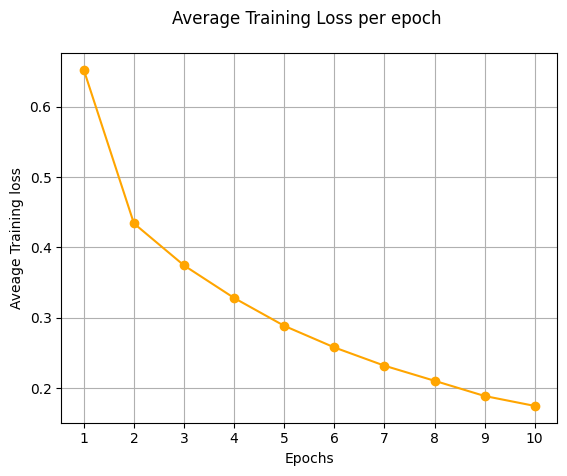

In [40]:
Epochs = range(1,11)

Training_loss=[training_loss_epoch_0_avg,training_loss_epoch_1_avg,training_loss_epoch_2_avg,training_loss_epoch_3_avg,training_loss_epoch_4_avg,training_loss_epoch_5_avg,training_loss_epoch_6_avg,
               training_loss_epoch_7_avg,training_loss_epoch_8_avg,training_loss_epoch_9_avg]

# Create the plot
plt.plot(Epochs, Training_loss, marker='o',color='orange')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Aveage Training loss')
plt.title('Average Training Loss per epoch \n')

# Display the plot
plt.grid(True)
plt.xticks(Epochs)
plt.show()

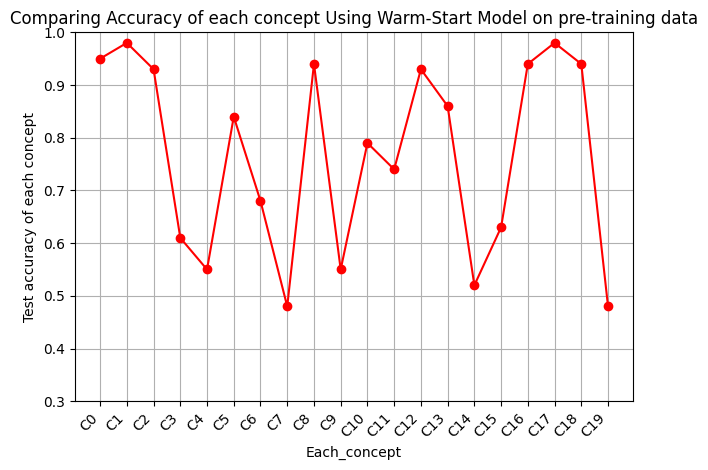

In [45]:
Each_concept = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
                      'C15', 'C16', 'C17', 'C18', 'C19']

# Create the plot
plt.plot(Each_concept, Final_test_accuracies, marker='o',color='red')

# Add labels and title
plt.xlabel('Each_concept')
plt.ylabel('Test accuracy of each concept')
plt.title('Comparing Test Accuracy of each concept Using Warm-Start Model on pre-training data')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.ylim(0.3, 1)
# Display the plot
plt.grid(True)
plt.tight_layout()  # To rotate the x-axis labels by 45 degrees.
plt.show()


In [46]:
end_time = time.time()
epoch_time = end_time - start_time
print()
print("Total Time to be taked to run this experiment:", epoch_time, "seconds")


Total Time to be taked to run this experiment: 456.0250310897827 seconds
